In [1]:
import requests # Импортируем библиотеку pandas и другие
from requests.exceptions import ConnectionError
from time import sleep
import json
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from pprint import pprint
from openpyxl import load_workbook
from openpyxl import Workbook
from pprint import pprint
import gspread # Библиотека для записи в Google sheets

In [2]:
import httplib2
import argparse
from googleapiclient import discovery
from googleapiclient.discovery import build
from oauth2client import client
from oauth2client import tools
from oauth2client import file
from oauth2client.file import Storage
import google.oauth2.credentials
import google_auth_oauthlib.flow
from oauth2client.service_account import ServiceAccountCredentials

In [3]:
import calendar

In [4]:
from matplotlib import pyplot as plt

#### Авторизация в Google Analytics Reporting API v4
После прохождения первичной авторизации - нет необходимости запускать данный блок повторно. Но, если credentials-файл не создан на компьтере - необходимо повторно пройти первичную авторизацию

In [5]:
SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
api_name = 'analyticsreporting'
api_version = 'v4'
client_secret = (r'/Users/egoshin/Downloads/cwa-analytics-client-secret-grants.json')
token_name = 'cwa_' + api_name + '.json' # Название и адрес файла, созданного при первой авторизации

In [6]:
# -------- Данные для работы с библиотекой 'gspread' --------

SCOPES = ['https://spreadsheets.google.com/feeds',  
          'https://www.googleapis.com/auth/drive']

# Создаем новый CREDENTIALS (т.к. предыдущий уже реализован для работы с API Google Aalytics) чтобы не было конфликта
CREDENTIALS = ServiceAccountCredentials.from_json_keyfile_name(
    r'/Users/egoshin/Downloads/cwa-d-egoshin-comradeweb-google-sheets-service-key.json', SCOPES)

# Формируем объект 'service', с помощью которого мы будем читать и записывать данные Google Sheets
http = CREDENTIALS.authorize(httplib2.Http())
discoveryUrl = ('https://sheets.googleapis.com/$discovery/rest?version=v4')
service = discovery.build('sheets', 'v4', http = http, discoveryServiceUrl=discoveryUrl)

# -------- Данные для работы с библиотекой 'gspread' --------
gc = gspread.authorize(CREDENTIALS) # Авторизация библиотеки 'gspread'
sh = gc.open('CWA budgets reporting') # Создание объекта файла в Google sheets

spreadsheet_id = '1_pgxcPDlFlCupgp2pmFdLBoXJQAymgpfIz0AVV7XshY'

In [7]:
# -------- Функция для обновления токена --------

config = json.load(open(token_name))
client_id = config['client_id'] # Client_id
client_secret = config['client_secret'] # Client_secret
refresh_token = config['refresh_token'] # Refresh_token
access_token = config['access_token']

def update_token(client_id, client_secret, refresh_token):
        
    url_token = 'https://accounts.google.com/o/oauth2/token'
    params = {
        'client_id': client_id, 
        'client_secret': client_secret, 
        'refresh_token': refresh_token, 
        'grant_type': 'refresh_token'
    }
    
    # Делаем post-запрос - тем самым, отдавая серверу на хранение токен, тем самым обновляя его
    r = requests.post(url_token, data=params)
    print('Токен выдан до {}'.format(datetime.today() + 
                                     timedelta(hours=1)))
    return r.json()['access_token']

In [8]:
token = update_token(client_id, client_secret, refresh_token)

Токен выдан до 2022-03-19 01:38:48.089185


In [ ]:
# Можно прочитать данные из файла
with open(r'/Users/egoshin/Downloads/cwa-ga-accounts.json') as f:
    data = json.load(f)
    f.close()
account = data

In [10]:
# -------- Указваем в хедере данные для авторизации --------

headers = {'Authorization': 'Bearer ' + token}

#### Даты, за которые будет создан репорт

In [11]:
if datetime.now().day == 1:
    month = str(datetime.now().month - 1) # Если уже первое число - меняем месяц на предыдущий
else:
    month = str(datetime.now().month)

In [12]:
if datetime.now().month < 10: # Для месяцев, порядковый номер меньше 10 добавляем "ноль" для корректного отображения
    month = '-0' + month
else:
    month = '-' + month

In [13]:
start_date = str(datetime.now().year) + month + '-01'
# end_date = (datetime.today() - timedelta(1)).strftime('%Y-%m-%d') # Предыдущий день
end_date = datetime.today().strftime('%Y-%m-%d') # Текущий день
start_date, end_date

('2022-03-01', '2022-03-19')

#### Репорт базовых метрик по Analytics Reporting API v4

In [14]:
# -------- Задаем параметры запроса --------

def reporting_api_v4_request(profile_id):
    url = 'https://analyticsreporting.googleapis.com/v4/reports:batchGet'
 
    metrics = [
        {'expression': 'ga:adCost'}, 
        {'expression': 'ga:adClicks'}, 
        {'expression': 'ga:CPC'}
    ]
    dimensions = [
        {'name': 'ga:source'}, 
        {'name': 'ga:medium'}
    ]
    filters = [{'filters': [
        {'dimensionName': 'ga:sourceMedium', 
         'operator': 'EXACT', 
         'expressions': ['google / cpc']}, 
        {'dimensionName': 'ga:sourceMedium', 
         'operator': 'EXACT', 
         'expressions': ['google / display']}
    ]}]
    
    # -------- Формируем тело запроса --------

    request = {
        'reportRequests': [
            {
                'viewId': profile_id,
                'dateRanges': [
                    {'startDate': start_date, 'endDate': end_date}
                ],
                'metrics': metrics,
                'dimensions': dimensions, 
                'dimensionFilterClauses': filters
            } 
        ]
    }
    
    # -------- Делаем запрос --------

    r = requests.post(url, json=request, headers=headers)
    data = r.json()
    
    report = data['reports'][0]['data']['rows'][0]['metrics'][0]['values']
    
    return report

In [15]:
temp = pd.DataFrame()

print('Report for: {} - {}'.format(start_date, end_date)) # Период, за который считаются расходы

# Чистим ячейки с данными
service.spreadsheets().values().clear(spreadsheetId=spreadsheet_id, range='Sheet1!E2:K').execute()

for key, value in account.items():
    login = key
    profile_id = value
    
    i=2
    try: # Если за период есть данные - создаем репорт на основе данных из API
        api_report = reporting_api_v4_request(profile_id)
        
        api_report.insert(0, start_date)
        api_report.insert(1, end_date)
        api_report.insert(2, login)
        
        body = {'values': [api_report]} # Добавим основные данные
        service.spreadsheets().values().append(spreadsheetId=spreadsheet_id, range='Sheet1!F'+str(i), 
                                               valueInputOption='USER_ENTERED', 
                                               body=body).execute()

        temp = temp.append([api_report], ignore_index=True)
        
        i+=1
        
    except: # Если данных нет - заполняем строку по шаблону (иначе будет ошибка)
        temp = temp.append([[start_date, end_date, login]], ignore_index=True)
        
        body = {'values': [[start_date, end_date, login]]}
        service.spreadsheets().values().append(spreadsheetId=spreadsheet_id, range='Sheet1!F'+str(i), 
                                               valueInputOption='USER_ENTERED', 
                                               body=body).execute()
        continue
    print('{} added'.format(login))
print('Report created: https://docs.google.com/spreadsheets/d/1_pgxcPDlFlCupgp2pmFdLBoXJQAymgpfIz0AVV7XshY/')

Report for: 2022-03-01 - 2022-03-19
CWA added
BYA added
BHS added
FAD added
PT added
SNC added
GRS added
VLG added
QW added
KEI added
LD added
GP added
ED added
OAH added
REG added
UNP added
AMT added
HGG added
SLG added
ALM added
SEL added
AMD added
NDI added
CTE added
TTR added
ANR added
INT added
SCL added
GLA added
TNS added
KER added
MIG added
CLN added
Report created: https://docs.google.com/spreadsheets/d/1_pgxcPDlFlCupgp2pmFdLBoXJQAymgpfIz0AVV7XshY/


In [16]:
# Получаем данные по одобренным бюджетам из ячеек google sheets для каждого клиента
approved_budgets = service.spreadsheets().values().batchGet(
    spreadsheetId=spreadsheet_id, ranges='Sheet1!C2:C41').execute()['valueRanges'][0]['values']

approved_budgets = pd.DataFrame(approved_budgets) # Преобразуем в дата-фрейм
approved_budgets.rename(columns={0: 'approved_budget'}, inplace=True)

In [17]:
temp = temp.rename(columns={0: 'start_date', 1: 'end_date', 2: 'name', 
                            3: 'ad_cost', 4: 'ad_clicks', 5: 'cpc'}).astype(
    {'ad_cost': float, 'ad_clicks': int, 'cpc': float}, 
    errors='ignore').round({'ad_cost': 2, 'cpc': 2})

temp = pd.concat([temp, approved_budgets], axis=1)

In [18]:
def str_to_int(row):
    i = row['approved_budget']
    if '$' or ',' in i:
        try:
            i = i.replace('$', '')
            i = i.replace(',', '')
            return float(i)
        except:
            return 0

In [19]:
temp['approved_budget'] = temp.apply(str_to_int, axis=1)
temp['spent_ratio'] = round((temp['ad_cost']/temp['approved_budget'])*100, 2)

In [20]:
temp

,start_date,end_date,name,ad_cost,ad_clicks,cpc,approved_budget,spent_ratio
0,2022-03-01,2022-03-19,CWA,119.74,15,7.98,500.0,23.95
1,2022-03-01,2022-03-19,BYA,2128.76,629,3.38,5000.0,42.58
2,2022-03-01,2022-03-19,BHS,11239.37,11591,0.97,20000.0,56.20
3,2022-03-01,2022-03-19,FAD,5121.19,1757,2.91,7000.0,73.16
4,2022-03-01,2022-03-19,PT,1239.24,194,6.39,2000.0,61.96
5,2022-03-01,2022-03-19,SNC,2971.77,1682,1.77,5000.0,59.44
6,2022-03-01,2022-03-19,GRS,2351.85,994,2.37,4500.0,52.26
7,2022-03-01,2022-03-19,VLG,701.19,120,5.84,1500.0,46.75
8,2022-03-01,2022-03-19,QW,650.61,366,1.78,1500.0,43.37
9,2022-03-01,2022-03-19,KEI,2875.51,1361,2.11,4500.0,63.90


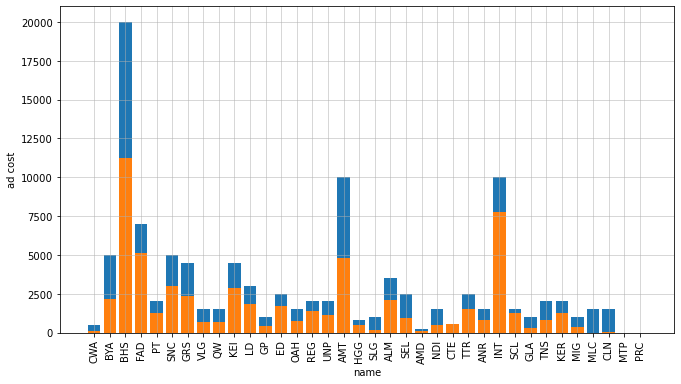

In [21]:
plt.figure(figsize=(11, 6))
plt.bar(temp.name, temp.approved_budget);
plt.bar(temp.name, temp.ad_cost);
plt.xlabel('name')
plt.ylabel('ad cost')
plt.xticks(rotation=90)
plt.grid(True, linewidth = 0.5)